In [79]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

In [80]:
import io

X = pd.read_csv('rotatingHyperplane.data', sep=' ', names = ["v"+str(i) for i in range(10)])
y = pd.read_csv('rotatingHyperplane.labels', sep=' ', names = ["y"])

In [87]:
def get_partial_data(data, frac = 0.1, top = True):
    size = int(len(data) * frac)
    if top:
        return data[:size]
    else:
        return data[-size:]

X_init = get_partial_data(X)
y_init = get_partial_data(y)
X_shift = get_partial_data(X, top = False)
y_shift = get_partial_data(y, top = False)

In [89]:
# from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

model = LogisticRegression().fit(X_init, np.ravel(y_init))
model_shift = LogisticRegression().fit(X_shift, np.ravel(y_shift))

In [90]:
import matplotlib.pyplot as plt

def distribution_change(old, new, N = 50, draw = False):
    range_left = min(min(old), min(new))
    range_right = max(max(old), max(new))
    old_hist = np.histogram(old, range=(range_left, range_right), bins = N)
    new_hist = np.histogram(new, range=(range_left, range_right), bins = N)
    
    if draw:
        plt.hist(old, range=(range_left, range_right), bins = N, label="old")
        plt.hist(new, range=(range_left, range_right), bins = N, label="new")
        plt.legend()
        plt.show()
    
    change = 0.0
    for x, y in zip(old_hist[0], new_hist[0]):
        change += min(x, y)

    return 1.0-(change/len(old))

for col in X_init.columns:
    print("Intersection distance dla zmiennej " + col + ": " + str(distribution_change(X_init[col], X_shift[col])))

Intersection distance dla zmiennej v0: 0.02805000000000002
Intersection distance dla zmiennej v1: 0.02805000000000002
Intersection distance dla zmiennej v2: 0.029850000000000043
Intersection distance dla zmiennej v3: 0.03154999999999997
Intersection distance dla zmiennej v4: 0.02795000000000003
Intersection distance dla zmiennej v5: 0.02795000000000003
Intersection distance dla zmiennej v6: 0.02529999999999999
Intersection distance dla zmiennej v7: 0.028549999999999964
Intersection distance dla zmiennej v8: 0.029549999999999965
Intersection distance dla zmiennej v9: 0.029900000000000038


Dla wszystkich zmiennych intersection distance jest niewielki.

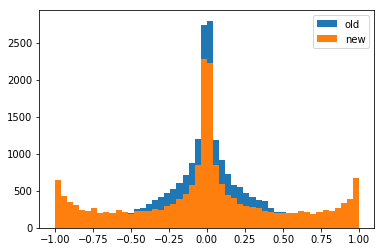

Intersection distance dla reszt: 0.2489


In [91]:
res_init = [x-y for x, y in zip(list(model.predict_proba(X_init)[:, 1]), list(y_init['y']))]
res_shift = [x-y for x, y in zip(list(model.predict_proba(X_shift)[:, 1]), list(y_shift['y']))]
print("Intersection distance dla reszt: " + str(distribution_change(res_init, res_shift, draw = True)))

Intersection distance dla reszt jest znaczący, a więc pomimo, że nie ma dryftu w rozkładzie żadnej ze zmiennych istnieje dryft w danych. <br />
Na powyższym histogramie widać, że model gorzej dopasowuje się do nowych danych.

## Odległość między wykresami PDP

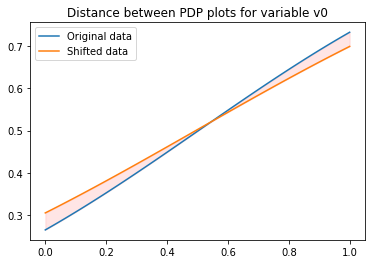

Distance: 0.02064213787454477


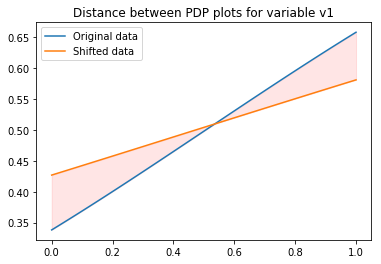

Distance: 0.043483126466151004


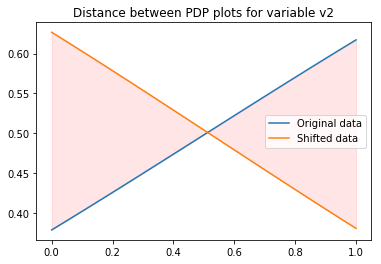

Distance: 0.12466138294752821


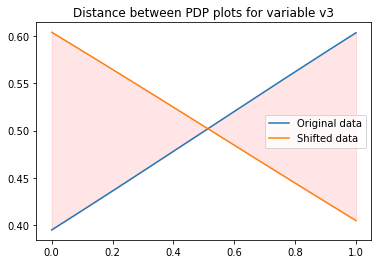

Distance: 0.10461974106514343


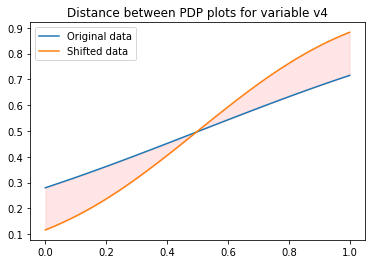

Distance: 0.1028985862699113


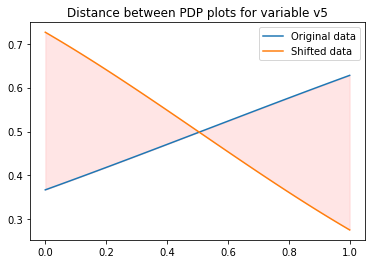

Distance: 0.1849638309096121


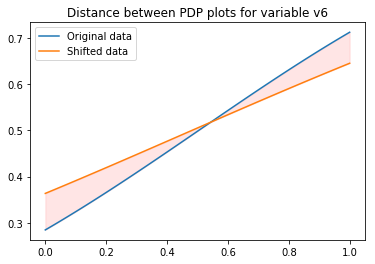

Distance: 0.03968950581541044


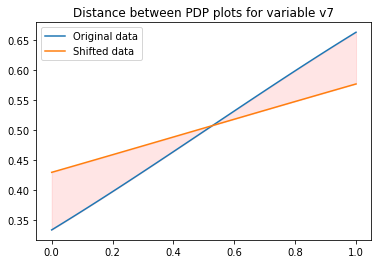

Distance: 0.047846173474299966


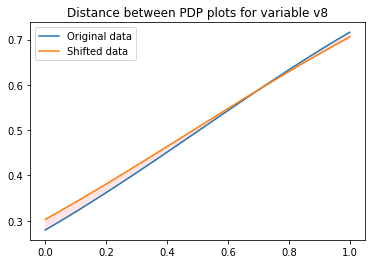

Distance: 0.01121578621995087


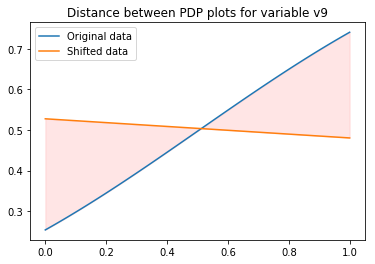

Distance: 0.14040076651456398


In [103]:
def get_pd(model, X, feature_name, range_min = 0.0, range_max = 1.0, N_POINTS = 101):
    xs = np.linspace(range_min, range_max, N_POINTS)
    ys = []
    for x in xs:
        X[feature_name] = x
        predictions = model.predict_proba(X)[:, 1]
        avg = sum(predictions)/len(predictions)
        ys.append(avg)
    return ys

def pd_distance(model_old, model_new, X_old, X_new, feature_name, N_POINTS = 101, draw = True):
    ys_old = get_pd(model_old, X_old, feature_name, N_POINTS = N_POINTS)
    ys_new = get_pd(model_new, X_new, feature_name, N_POINTS = N_POINTS)
    
    xs = np.linspace(0.0, 1.0, N_POINTS)
    distance = sum([abs(x-y) for x, y in zip(ys_old, ys_new)])/(N_POINTS-1)

    # draw plots
    if draw:
        plt.plot(xs, ys_old, label="Original data")
        plt.plot(xs, ys_new, label="Shifted data")
        plt.title("Distance between PDP plots for variable " + feature_name)
        plt.fill_between(xs, ys_old, ys_new, alpha = 0.1, color = 'red')
        plt.legend()
        plt.show()
    
    return distance

for i in range(0, 10):
    print("Distance: " + str(pd_distance(model, model_shift, X_init.copy(), X_shift.copy(), "v"+str(i))))

Znaczące pole pomiędzy wykresami PDP dla niektórych zmiennych oznacza, że mimo iż rozkład żadnej z nich nie zmienił się (mały distribution distance) to nastąpił dryft w danych (wpływ zmiennych na odpowiedź).